<h2>Indexing the document collection</h2>

<h3>Settings & utilities</h3>

In [1]:
#imports
import xml.etree.ElementTree as ET
import os
import string
import numpy as np
from matplotlib import pyplot as plt
import math
import re    #RegEx
import spacy #lemmatization
from collections import OrderedDict
import pickle #serialize object read/write files
import time

#Local import
%run "contraction.py"

#config
%config InlineBackend.figure_format = 'retina'

<h3>Utilities</h3>


In [2]:
def divideList(list_in, percentage, seed):
    if percentage < 0 or percentage > 1:
        print('Percentage must be between 0 and 1')
        return []
    np.random.seed(seed)
    idx = np.random.shuffle(list_in)
    if percentage == 1:
        return list_in
    i = round(len(list_in) * percentage)
    return list_in[0:i]

#divideList([0,1,2,3,4,5,6,7,8,9], 0.7, 1)

<h3>Load stopwords</h2>

In [3]:
#Load a stopword list NLTK
gist_file = open("stopwords.txt", "r")
try:
    content = gist_file.read()
    stopwords = content.split(",")
finally:
    gist_file.close()

<h3>Load document collection</h3>

In [4]:
#path to the document collection
collection_path = 'C:/Users/Stefano Marzo/Documents/DCU Master Dublin/05 Second semester modules/CA6005 Mechanics of search/01 Assignment/COLLECTION'

def getDocumentList(path):
    return os.listdir(path)
    
#generate document name list
doc_list = getDocumentList(collection_path)

<h3>Load queries</h3>

In [5]:
queries_path = 'C:/Users/Stefano Marzo/Documents/DCU Master Dublin/05 Second semester modules/CA6005 Mechanics of search/01 Assignment/topics'

#generate query name list
queries_list = getDocumentList(queries_path)

<h3>Classes for handle XML documents and the Document Collection</h3>

In [6]:
#relevant document tags 
DOCID = 'DOCID'
HEADLINE = 'HEADLINE'
TEXT = 'TEXT'

class XmlDoc:
    def __init__(self, xml):
        tree = ET.parse(xml)
        root = tree.getroot()
        for id in root.iter(DOCID):
            self.id = id.text
        for h in root.iter(HEADLINE):
            self.headline = h.text
        for t in root.iter(TEXT):
            self.text = t.text
        self.processedText = processText(self.text)
        self.tfIndex = self.__getTF__()
    
    def getId(self):
        return self.id
    
    def __getTF__(self):
        #tf is on text, not headline
        #tf has 2 possible implementations
        #1. f/max_occurance of most frequent term
        #2. f/number_different_terms or number_total_terms?
        num_terms = len(self.processedText)
        tfIndex = {}
        for term in self.processedText:
            if term not in tfIndex: #save some time
                tfIndex[term] = self.processedText.count(term)/num_terms
        return tfIndex

class DocumentCollection:
    def __init__(self, path, doc_list, fileName='document-collection.dictionary'):
        self.__name__ = 'Document Collection'
        
        #List of XmlDoc object
        self.docs = {}
        for d in doc_list:
            xmlDocument = XmlDoc(path + '/' + d)
            self.docs[xmlDocument.id] = xmlDocument
        
        #Inverted index
        self.inverted_index = {}
        for id in self.docs.keys():
            for term in self.docs[id].processedText:
                if term in self.inverted_index:
                    self.inverted_index[term].add(id)
                else: self.inverted_index[term] = {id}
        
        #Table of IDF
        self.idf = {}
        for term in self.inverted_index.keys():
            self.idf[term] = np.log(len(self.docs) / len(self.inverted_index[term]))
        
        with open(fileName, 'wb') as dictionary_file:
            pickle.dump(self, dictionary_file)
            
    
    def getRelevance(self, documentID, term):
        try:
            return self.docs[documentID].tfIndex[term] * self.idf[term]
        except: 
            return 0


<h3>Classes for handle XML queries and the Query Collection</h3>

In [7]:
#relevant document tags 
QUERYID = 'QUERYID'
TITLE = 'TITLE'
DESC = 'DESC'

class XmlQuery:
    def __init__(self, xml):
        tree = ET.parse(xml)
        root = tree.getroot()
        for id in root.iter(QUERYID):
            self.id = id.text
        for h in root.iter(TITLE):
            self.title = h.text
        for t in root.iter(DESC):
            self.desc = t.text 
        self.processedText = processText(self.title)
        self.tfIndex = self.__getTF__()
        
    def __getTF__(self):
        #tf is on text, not headline
        #tf has 2 possible implementations
        #1. f/max_occurance of most frequent term
        #2. f/number_different_terms or number_total_terms?
        num_terms = len(self.processedText)
        tfIndex = {}
        for term in self.processedText:
            if term not in tfIndex: #save some time
                tfIndex[term] = self.processedText.count(term)/num_terms
        return tfIndex

class QueryCollection:
    def __init__(self, path, query_list, fileName='query-collection.dictionary'):
        #List of XmlDoc object
        self.queries = {}
        for d in query_list:
            xmlQuery = XmlQuery(path + '/' + d)
            self.queries[xmlQuery.id] = xmlQuery
        
        #Inverted index
        self.inverted_index = {}
        for id in self.queries.keys():
            for term in self.queries[id].processedText:
                if term in self.inverted_index:
                    self.inverted_index[term].add(id)
                else: self.inverted_index[term] = {id}
        
        #Table of IDF
        self.idf = {}
        for term in self.inverted_index.keys():
            self.idf[term] = np.log(len(self.queries) / len(self.inverted_index[term]))
        
        with open(fileName, 'wb') as dictionary_file:
            pickle.dump(self, dictionary_file)
            
    
    def getRelevance(self, queryID, term):
        try:
            return self.queries[queryID].tfIndex[term] * self.idf[term]
        except: 
            return 0
    
    
            
#xmlq = XmlQuery(queries_path + '/' + queries_list[0])
#xmlq.title

<h2>Processing text</h2>

In [8]:
#Process text to meet the IR requirements

# Regular expression for finding contractions
contractions_re=re.compile('(%s)' % '|'.join(contractions_dict.keys()))

# Function for expanding contractions
def expand_contractions(text,contractions_dict=contractions_dict):
    def replace(match):
        return contractions_dict[match.group(0)]
    return contractions_re.sub(replace, text)

# Lemmatization
# https://www.analyticsvidhya.com/blog/2019/08
#/how-to-remove-stopwords-text-normalization-nltk-spacy-gensim-python
#/?utm_source=blog&utm_medium=information-retrieval-using-word2vec-based-vector-space-model
nlp = spacy.load('en_core_web_sm',disable=['ner','parser'])
nlp.max_length=5000000

def lemmatize(x):
    return ' '.join([token.lemma_ for token in list(nlp(x)) if (token.is_stop==False)])

#Returns a list of relevant terms
def processText(text):
    #remove punctuation and stopwords
    #remove single punctuation characters, remove points (not separated from string), lower case all 
    if not isinstance(text, str) :
        return []
    #lower the text
    text = text.lower()
    #expand contractions
    text = expand_contractions(text)
    #lemmatize
    text = lemmatize(text)
    return list(filter(lambda el: el not in string.punctuation 
                       and el not in stopwords, 
                       text.translate(str.maketrans('', '', '.')).split()))

#processText('asked processed figuring the foundation')
#processText("O'reilly's")
#processText("I'm Stefano")

<h2>Create Document Collection and Query Collection objects</h2>

In [9]:
#seed for random number
seed = 1

#divide the document collection (get pd% of documents)
pd = 0.01
doc_list = divideList(doc_list, pd, seed)

#divide the query collection (get pq% of documents)
pq = 1
queries_list = divideList(queries_list, pq, seed)

#Compute or read document collection
computeDocumentCollection = False
documentCollectionFileName = 'document-collection.dictionary'

#create a Document collection object
if computeDocumentCollection or not os.path.isfile(documentCollectionFileName):
    start = time.time()
    document_collection = DocumentCollection(collection_path, doc_list, documentCollectionFileName)
    end = time.time()
    print('Document Collection Computed in ' + str(round(end - start, 4)) + 's')
else:
    start = time.time()
    with open(documentCollectionFileName, 'rb') as dictionary_file:
        document_collection = pickle.load(dictionary_file) 
    end = time.time()
    print('Document Collection Loaded in ' + str(round(end - start, 4)) + 's')

#Compute or read query collection
computeQueryCollection = False
queryCollectionFileName = 'query-collection.dictionary'

#create a Query collection object
if computeQueryCollection or not os.path.isfile(queryCollectionFileName):
    start = time.time()
    query_collection = QueryCollection(queries_path, queries_list, queryCollectionFileName)
    end = time.time()
    print('Query Collection Computed in ' + str(round(end - start, 4)) + 's')
else:
    start = time.time()
    with open(queryCollectionFileName, 'rb') as dictionary_file:
        query_collection = pickle.load(dictionary_file) 
    end = time.time()
    print('Query Collection Loaded in ' + str(round(end - start, 4)) + 's')

#pointer to inverted index
inverted_index = document_collection.inverted_index

Document Collection Computed in 39.1736s
Query Collection Computed in 0.8778s


<h2>Heaps' law</h2>
<h2>$M = kT^b$</h2>
<p>where:</p>
<ul>
    <li>$M$ is the document length </li>
    <li>$T$ is the number of distinct terms, i.e. <i>Token</i> </li>
    <li>$k$ is a parameter s.t. $10 \leq k \leq 100$ </li>
    <li>$b$ is a parameter s.t. $0.4 \leq k \leq 0.6$ </li>
</ul>

In [10]:
k = 18
b = .6

#heap function
def heaps(k,T,b):
    return np.power(T, b) * k

In [11]:
#documents data (limit to L documents)
L = 20 #300 for final result
word_list = []
unique_words = []
for doc in list(document_collection.docs.keys())[0:L]:
    word_list += document_collection.docs[doc].processedText

for i, w in enumerate(word_list):
    unique_words += [len(set(word_list[0:i]))]

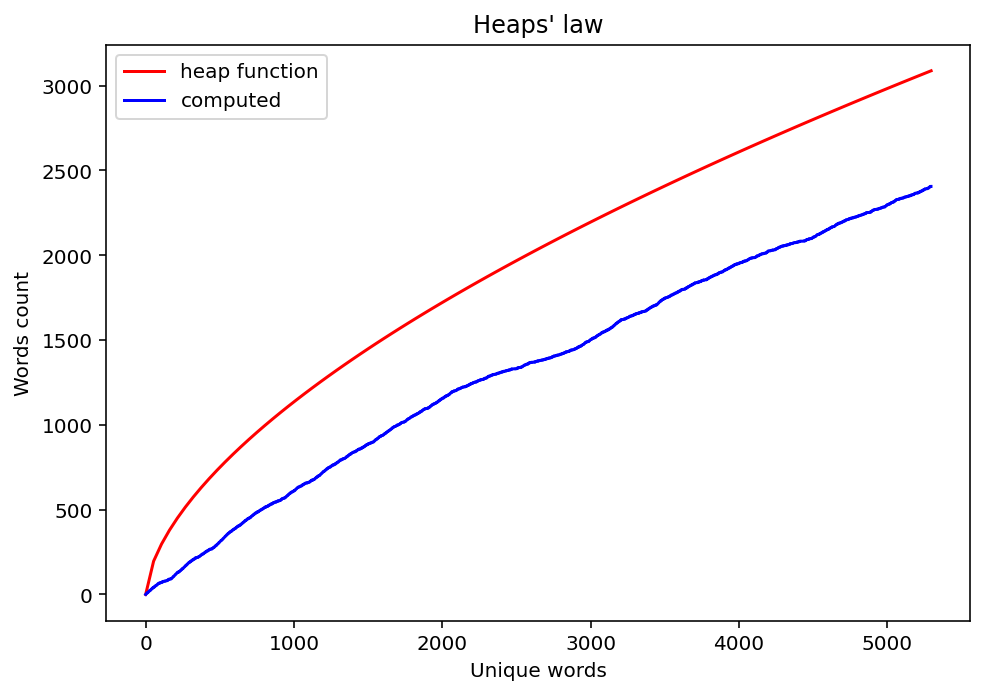

In [12]:
#plot
x = np.linspace(0, len(word_list), 100)

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
plt.plot(x, heaps(k, x, b), color='red', label='heap function')
plt.plot(np.arange(len(unique_words)), unique_words, color='blue', label='computed')
ax.set_xlabel('Unique words')
ax.set_ylabel('Words count')
ax.set_title('Heaps\' law')
plt.legend()
plt.show()

<h2>Zipf's law</h2>
<h2>$f = \frac{k}{r}$</h2>
<p>where:</p>
<ul>
    <li>$f$ is the word frequency</li>
    <li>$k$ is a parameter that change with the language (0.1 for english)</li>
    <li>$r$ is the <i>rank</i> of the word</li>
</ul>

In [13]:
#Zipf's formula
kz = 1
frequencies = []
ranks = []
tot_words = len(inverted_index)
for word in inverted_index.keys():
    frequencies += [len(inverted_index[word])]
    ranks += [np.log(kz/frequencies[-1])]

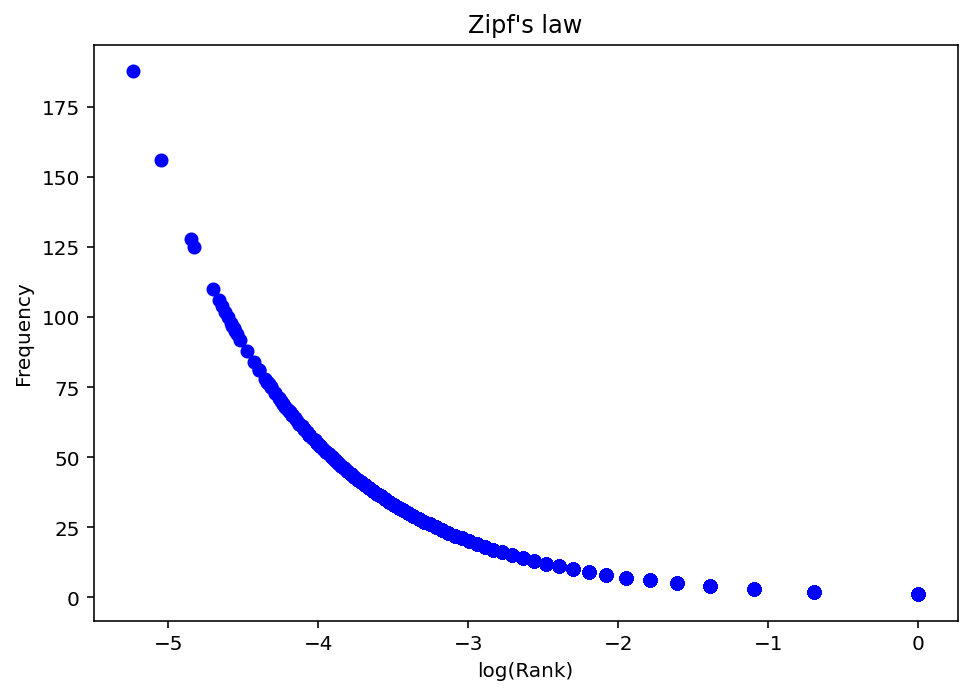

In [14]:
#Plot
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
plt.scatter(ranks, frequencies, color='blue')
ax.set_xlabel('log(Rank)')
ax.set_ylabel('Frequency')
ax.set_title('Zipf\'s law')
plt.show()

<h2>Get most significant words</h2>
<h3>Attempt #1: frequency density</h3>

In [15]:
#try to get the most frequent terms in a significant way

#Point density
frequency_list = frequencies[:]
frequency_list.sort()

#radius = 2
#precise but time expensive
def getFrequencyDensity(frequency_list, radius):
    frequency_density = []
    for i in range(len(frequency_list)):
        count = 0
        lim_inf = frequency_list[i] - radius
        lim_sup = frequency_list[i] + radius
        j = i
        while j >= 0 and frequency_list[j] >= lim_inf:
            count += 1
            j -= 1
        j = i
        while j < len(frequency_list) and frequency_list[j] <= lim_sup:
            count += 1
            j += 1
        frequency_density += [count/(2*radius)]
    return frequency_density

#frequency_density = getFrequencyDensity(frequency_list, radius)
"""
for word in inverted_index.keys():
    if len(inverted_index[word]) > 300:
        print(word)
"""

'\nfor word in inverted_index.keys():\n    if len(inverted_index[word]) > 300:\n        print(word)\n'

In [16]:
#Plot the frequency density 
"""
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
plt.scatter(np.arange(len(frequency_density)), frequency_density, color='blue')
ax.set_xlabel('index')
ax.set_ylabel('Frequency density')
ax.set_title('Zipf\'s law')
plt.show()
"""

"\nfig = plt.figure()\nax = fig.add_axes([0,0,1,1])\nplt.scatter(np.arange(len(frequency_density)), frequency_density, color='blue')\nax.set_xlabel('index')\nax.set_ylabel('Frequency density')\nax.set_title('Zipf's law')\nplt.show()\n"

<h2>Get most significant words</h2>
<h3>Attempt #2: percentage</h3>

In [17]:
#get the most x% frequent terms
percentage = .00005

def getHighestValue(data, percentage):
    data_size = len(frequency_list)
    i = data_size * percentage
    return data[-round(i)]


#len(frequency_list)
def printMostFrequentTerms(inverted_index, frequency_list, percentage):
    for word in inverted_index.keys():
        if len(inverted_index[word]) > getHighestValue(frequency_list, percentage):
            print(word)

#printMostFrequentTerms(inverted_index, frequency_list, percentage)

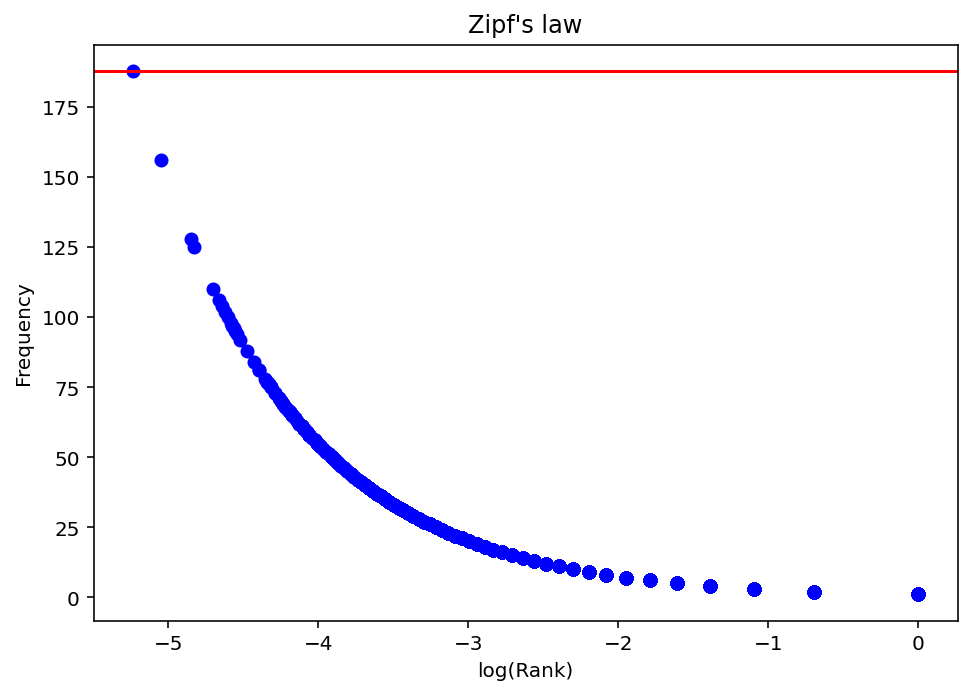

In [18]:
#plot the results
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
plt.scatter(ranks, frequencies, color='blue')
plt.axhline(y = getHighestValue(frequency_list, percentage), color = 'r', linestyle = '-')
ax.set_xlabel('log(Rank)')
ax.set_ylabel('Frequency')
ax.set_title('Zipf\'s law')
plt.show()

<h2>Term frequency: $tf$</h2>
<p>The occurencies of a term in a document divided by the total number of word in a document</p>
<p>Normalized term frequency for a term $j$ in a document $i$</p>
<h2>$tf_{ij} = \frac{f_{ij}}{M}$</h2>
<p>where $M$ is the number of different terms.</p>

In [19]:
#function
def getTermFrequency(document):
    doc = processText(readDocument(collection_path + '/' + document).text)
    num_terms = len(doc)
    tfIndex = {}
    for term in doc:
        tfIndex[term] = doc.count(term)/num_terms
    return tfIndex
#object
#XmlDoc(collection_path + '/' + doc_list[0]).getTF()

<h2>Inverse document frequency: $idf$</h2>
<p>for a term $j$</p>
<h2>$idf_{j} = log(\frac{N}{df_j})$</h2>
<p>where $N$ is the number of documents in the collection and $df_j$ is the number of documents that contain the term $j$.</p>

In [20]:
#Function
def getInverseDocumentFrequency(inverted_index, N):
    idf = {}
    for term in inverted_index.keys():
        idf[term] = np.log(N / len(inverted_index[term]))
    return idf
#getInverseDocumentFrequency(inverted_index, len(doc_list))

#Class
#document_collection.getIDF()

<h2>Balance exhaustivity $tf$ and specificity $idf$</h2>
<p>Any term in the collection can be attributed to a level of relevance calculated as</p>
<h2>$tf_{ij} \times idf_{j}$</h2>

In [21]:
document_collection.getRelevance(
    document_collection.docs[list(document_collection.docs.keys())[0]].id, 'buckle')

0

In [22]:
#is istance of str, else []
#lower
#expand contractions
#lemmatize
#remove punctuation
#remove stopwords
#remove single points
def getQueryVector(query):
    q = processText(query.title)
    qf = {}
    for term in q:
        if term not in qf:
            qf[term] = 1
        else:
            qf[term] += 1
    return qf


def getRelatedDocument(document_collection, query):
    s = set() #all document related with query
    query = getQueryVector(query)
    for term in query:
        if term in document_collection.inverted_index:
            s = s.union(set(document_collection.inverted_index[term]))
    return s, query


def getVectorSpace(document_collection, query):
    docs, query = getRelatedDocument(document_collection, query)
    space = {}
    for d in docs:
        space[d] = [document_collection.getRelevance(d, term) for term in query]
    return space

#getVectorSpace(document_collection, xmlq)
#document_collection.inverted_index['kiesbauer']

<h2>Vector space model VSM</h2>

In [23]:
class VectorSpaceModel:
    def __init__(self, document_collection, query_collection, fileName = 'vector-space-model.dictionary'):
        self.document_collection = document_collection
        self.query_collection = query_collection
        self.unique_query_terms = set(query_collection.inverted_index.keys())
        self.space = {}
        for id in document_collection.docs.keys():
            #for term in document_collection.docs[id].processedText:
            self.space[id] = [document_collection.getRelevance(id, t) for t in self.unique_query_terms]
        with open(fileName, 'wb') as dictionary_file:
            pickle.dump(self, dictionary_file)
    
    def vectorizeXmlQuery(self, xmlQuery):
        vectorizedQuery = [self.query_collection.getRelevance(xmlQuery.id, t) for t in self.unique_query_terms]
        return vectorizedQuery
    
    #search based on unseen queries
    def vectorizeStringQuery(self, strQuery):
        strQuery = processText(strQuery)
        #calculate tf
        q_len = len(strQuery)
        tfIndex = {}
        for term in strQuery:
            tfIndex[term] = strQuery.count(term)/q_len
        #calculate relevance
        q_relevance = {}
        for term in strQuery:
            try:
                q_relevance[term] = tfIndex[term] * self.query_collection[term]
            except:
                q_relevance[term] = 0
        vectorizedQuery = [q_relevance[t] if t in q_relevance else 0 for t in self.unique_query_terms]
        return vectorizedQuery
    
    def cosineSimilarity(self, vect1, vect2):
        norm1 = np.linalg.norm(vect1)
        norm2 = np.linalg.norm(vect2)
        dotP = np.dot(vect1, vect2)
        #origin vector is equal to itself
        if dotP == 0 and norm1 == 0 and norm2 == 0:
            return 1
        #origin vector is not equal to any vector but itself
        if norm1 == 0 or norm2 == 0:
            return 0
        return np.dot(vect1, vect2) / (norm1 * norm2)
    
    def computeSimilarity(self, query):
        if isinstance(query, str):
            v_query = self.vectorizeStringQuery(query)
        if isinstance(query, XmlQuery):
            v_query = self.vectorizeXmlQuery(query)
        simDict = {}
        for id in self.space.keys():
            v_space = self.space[id]
            similarity = self.cosineSimilarity(v_space, v_query)
            if similarity not in simDict:
                simDict[similarity] = [id]
            else:
                simDict[similarity] += [id]
        return simDict
    
    def getRank(self, query):
        simDict = self.computeSimilarity(query)
        relevance = sorted(list(simDict.keys()), reverse=True )#list of relevance results
        rank = []
        for r in relevance:
            rank += simDict[r]
        return rank, relevance
    
    #if 
    def getQueryResults(self, query, topNumber=5):
        start = time.time()
        rankedDocuments, relevance = self.getRank(query)
        end = time.time()
        
        if isinstance(query, str):
            queryText = query
        if isinstance(query, XmlQuery):
            queryText = query.title
        
        print(str(topNumber) + ' top results for ' + queryText + ' (' + str(round(end-start, 4)) + 's)')
        for i in range(len(relevance[0:topNumber])):
            if relevance[i] != 0:
                print('Result: ' + rankedDocuments[i] + ', Relevance: ' + str(relevance[i]))
        

In [24]:
#Init vector space model
vectorSpaceFile = 'vector-space-model.dictionary'
computeVSM = False
if computeVSM or not os.path.isfile(vectorSpaceFile):
    start = time.time()
    vsm = VectorSpaceModel(document_collection, query_collection, vectorSpaceFile)
    end = time.time()
    print('Vector Space Model Computed in ' + str(round(end - start, 4)) + 's')
else:
    start = time.time()
    with open(vectorSpaceFile, 'rb') as dictionary_file:
        vsm = pickle.load(dictionary_file) 
    end = time.time()
    print('Vector Space Model Loaded in ' + str(round(end - start, 4)) + 's')

Vector Space Model Computed in 0.3968s


In [29]:
vsm.getQueryResults(query_collection.queries['10.2452/349-AH'], 100)

5 top results for  Nixon ' s Death (0.1288s)
Result: LA040394-0128, Relevance: 0.6734685813686927
Result: LA051294-0091, Relevance: 0.653672348802548
Result: LA011694-0272, Relevance: 0.4032136919584477
Result: LA081494-0168, Relevance: 0.3367148501096677
Result: LA102694-0137, Relevance: 0.2237793244667901
5 top results for nixon death (0.0511s)
Result: LA020194-0244, Relevance: 1


In [26]:
#Produce output
#document_collection.docs['GH951220-000145']